# **STAT 306 Group Project: Predicting Sleep Efficiency**

>##### By: Pahul Brar, Diana Liang, Peng Xie, Jonathan Tuazon

## 1. Introduction

Sleep is an essential aspect of human life, and its quality has a significant impact on our overall health and well-being. However, many people struggle with getting good quality sleep, which can lead to a variety of negative health outcomes. To address this issue, we have undertaken a project to predict sleep efficiency using various data sources and learning techniques.

In this project, we aim to develop a model that can accurately predict the quality of sleep based on various factors, such as the duration of sleep, caffeine consumption, deep sleep percentage, and light sleep percentage. By predicting sleep efficiency, we can identify potential causes of poor sleep and provide recommendations to improve it.

To achieve this goal, we will be collecting data from the Kaggle and analyze the data to identify patterns and trends that are associated with sleep efficiency. Finally, we will develop a model that can predict sleep efficiency based on these factors.

The potential benefits of this project are important, as improving sleep efficiency can have a positive impact on many areas of our lives. We hope that our research will lead to a better understanding of sleep and its relationship with various lifestyle factors, and ultimately contribute to the development of more effective interventions to improve sleep quality.

**Research Question:** "Research question goes here"

(TO EDIT AND EXPAND) Which set of factors play a significant role in accurately predicting sleep efficiency?

"Motivation goes here"

(TO EDIT AND EXPAND) In this project we aim to determine, using data collected by a team of researchers from the University of Oxfordshire, what factors play a significant role in accurately predicting sleep efficiency. We attempt to use either a linear model or a quadratic model, whichever is more suitable and gives us better results to approach this. The motivation behind this is that sleep is a crucial element many college students are forced to ignore and rather just rely on caffeine consumption to function. We want to determine if any relationship exists between items like Coffee, Cigarettes, Alcohol, or sleep patterns and sleep efficiency. It has been repeatedly proved that sleep deprivation leads to a reduction in alertness, attention, and other basic cognitive processes (Garcia et al.).  “Sleep deprivation is more detrimental to cognitive functions that depend more on mental effort and cognitive capacity,” such as reaction time (Kusztor et al.). Sleep is an important aspect for humans, and thus we want to explore how to maximize its efficiency and determine if any factors are more detrimental to it.

#### Brief Description of the Variables in the Dataset

"Brief Description goes here"

(TO EDIT AND EXPAND) The dataset used in this project is sourced from [Kaggle](https://www.kaggle.com/datasets/equilibriumm/sleep-efficiency). The sleep efficiency data was collected in a study conducted by a team of researchers from the University of Oxfordshire. Over the course of several months, the team collected data using self-reported surveys, actigraphy, and polysomnography from participants they recruited from the local community in the UK. The source did not provide any further information.

The following include all the variables measured in the dataset:
- Age (years) 
    - Age of the individual
- Gender (0=Female; 1=Male)
    - Categorical: Subject is male or female
- Bedtime (timestamp: YYYY-MM-DD HH:MM: SS) 
    - Time subject goes to bed
- Wakeup time (timestamp: YYYY-MM-DD HH:MM: SS)
    - Time subject wakes up
- Sleep duration (hours)
    - The total amount of time spent sleeping
- Sleep efficiency
    - proportion of time in bed spent asleep
- REM sleep percentage (%)
    - percentage of sleep duration spent in REM sleep
- Deep sleep percentage (%)
    - percentage of sleep duration spent in Deep sleep
- Light sleep percentage (%)
    - percentage of sleep duration spent in Light sleep
- Awakenings
    - number of times the subject woke up during the night
- Caffeine Consumption (mg)
    - Amount of caffeine consumed in the 24 hours prior to bedtime
- Alcohol Consumption (oz)
    - Amount of alcohol consumed in the 24 hours prior to bedtime
- Smoker (0=Nonsmoker; 1=Smoker)
    - Categorical: subject smokes or does not smoke
- Exercise frequency
    - number of times the subject exercises each week

## 2. Analysis

#### Loading Packages and Cleaning the Dataset

"This section should start with suitable visualizations of the data, and a summary of any key features. The methodology should then be applied to the data to address the question(s) of interest motivating the study."

To begin our analysis, we'll read the dataset into a dataframe and omit any entries with missing data. Furthermore we'll be dropping ID, which is unrelated to predicting sleep efficiency and was just a means for the original study to keep track of participants. As well, we decided to drop Bedtime and Wakeup time because....
TODO: explain why we are excluding Bedtime,Wakeup.time And why (if needed) OR that we are extracting time only from the date-time and converting it into a numeric based on seconds. Are we creating dummy variables here?

TODO: include a very brief summary of what the general methodogy framework.

In [48]:
library(tidyverse)
library(leaps)
library(lubridate)
library(cowplot)
library(ggcorrplot)
library(car)
library(ggplot2)

In [44]:
data <- read.csv("data/Sleep_Efficiency.csv") |>
    relocate(Sleep.efficiency) |>
    na.omit(data) |>
    #select(-c(ID))
    select(-c(Bedtime,Wakeup.time,ID))

data$Smoking.status <- ifelse(data$Smoking.status=="Yes",1,0) |>
    as.factor()
data$Gender <- ifelse(data$Gender=="Male",1,0) |>
    as.factor()
df <- read.csv("data/Sleep_Efficiency.csv") |>
    relocate(Sleep.efficiency) |>
    na.omit(data) |>
    select(Sleep.efficiency,Bedtime,Wakeup.time)

#data$Bedtime <- hour(data$Bedtime)*3600 + minute(data$Bedtime)*60 + second(data$Bedtime)
#data$Wakeup.time <- hour(data$Wakeup.time)*3600 + minute(data$Wakeup.time)*60 + second(data$Wakeup.time)
head(data)

n <- nrow(data)
dim(data)

,Sleep.efficiency,Age,Gender,Sleep.duration,REM.sleep.percentage,Deep.sleep.percentage,Light.sleep.percentage,Awakenings,Caffeine.consumption,Alcohol.consumption,Smoking.status,Exercise.frequency
,<dbl>,<int>,<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,0.88,65,0,6,18,70,12,0,0,0,1,3
2,0.66,69,1,7,19,28,53,3,0,3,1,3
3,0.89,40,0,8,20,70,10,1,0,0,0,3
4,0.51,40,0,6,23,25,52,3,50,5,1,1
5,0.76,57,1,8,27,55,18,3,0,3,0,3
7,0.54,27,0,6,28,25,47,2,50,0,1,1


[1] 388  12

After preprocessing and cleaning, there are 14 variables and 388 entries in the dataset. 

#### Summary of Statistics

In [45]:
summary(data)

 Sleep.efficiency      Age        Gender  Sleep.duration   REM.sleep.percentage
 Min.   :0.5000   Min.   : 9.00   0:194   Min.   : 5.000   Min.   :15.00       
 1st Qu.:0.7000   1st Qu.:29.00   1:194   1st Qu.: 7.000   1st Qu.:20.00       
 Median :0.8200   Median :41.00           Median : 7.500   Median :22.00       
 Mean   :0.7893   Mean   :40.83           Mean   : 7.451   Mean   :22.68       
 3rd Qu.:0.9000   3rd Qu.:52.00           3rd Qu.: 8.000   3rd Qu.:25.00       
 Max.   :0.9900   Max.   :69.00           Max.   :10.000   Max.   :30.00       
 Deep.sleep.percentage Light.sleep.percentage   Awakenings   
 Min.   :18.00         Min.   : 7.0           Min.   :0.000  
 1st Qu.:51.00         1st Qu.:15.0           1st Qu.:1.000  
 Median :58.00         Median :18.0           Median :1.000  
 Mean   :52.82         Mean   :24.5           Mean   :1.619  
 3rd Qu.:63.00         3rd Qu.:24.0           3rd Qu.:3.000  
 Max.   :75.00         Max.   :63.0           Max.   :4.000  
 Caffe

From this summary, we see that sleep efficiency ranges from 0.5 to 0.99 and that the average sleep efficiency measured is 0.79. Furthermore, the average age of all the participants is 40.83 and there are equal number of male and female participants. Interestingly, more than half participants included in the cleaned dataset did not ingest any caffiene throughout the entire day as the median caffiene consumption is 0.0mg, while the average caffiene consumed is 22.68mg. This is also the case with alcohol consumption, where the median is 0.0oz, while the average alcohol consumed is 1.15oz. 

#### Correlation Matrix

Next, we'll compute and visualize a correlation matrix to better understand the relationships between the variables.

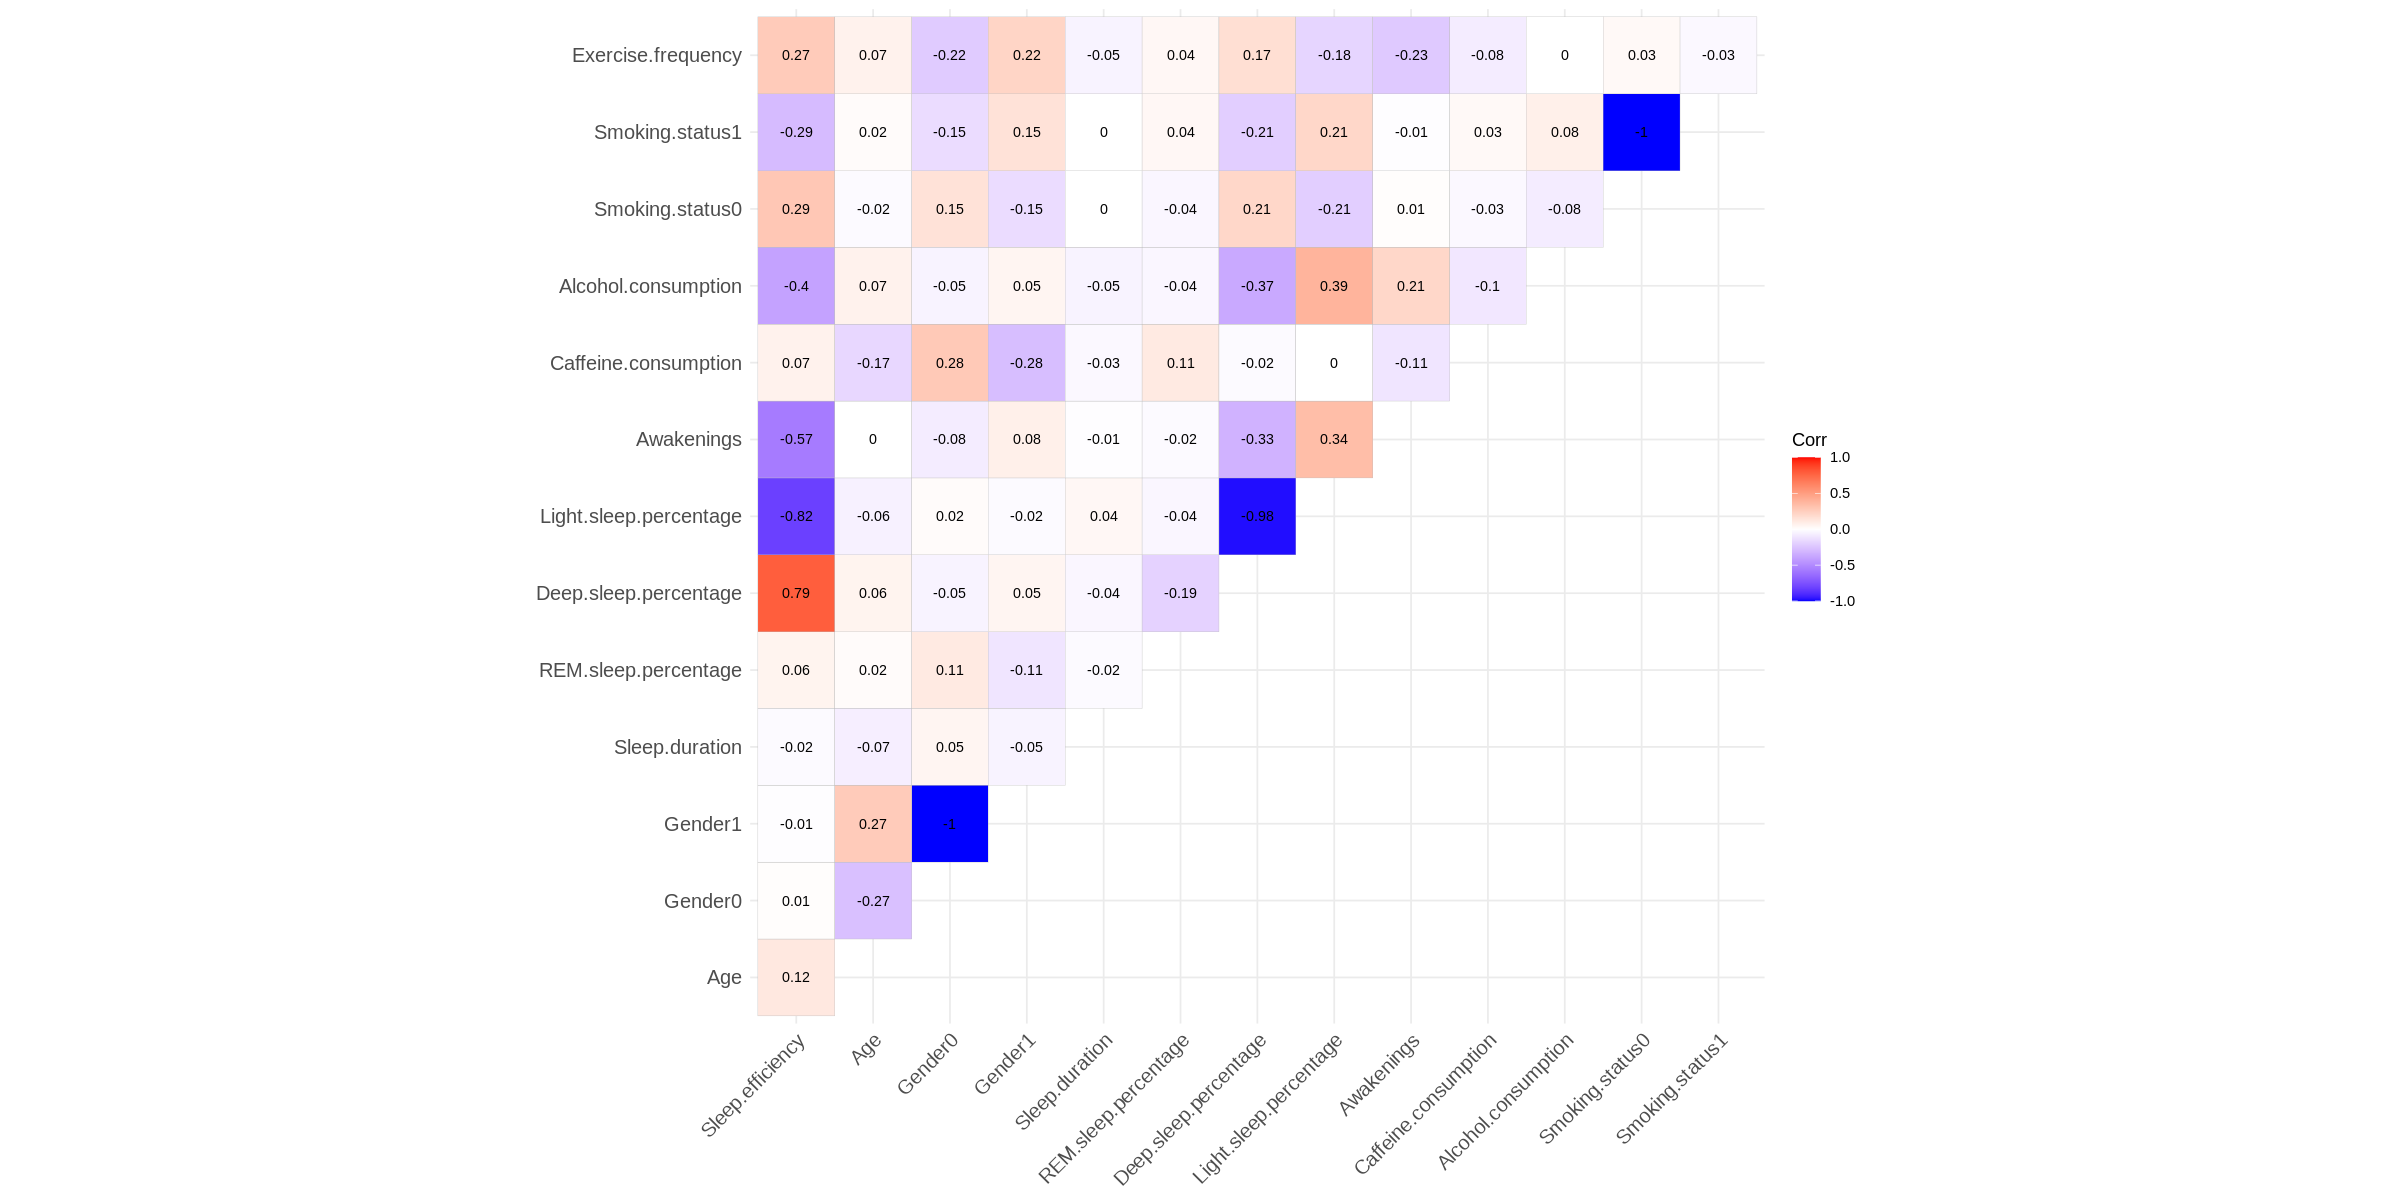

In [46]:
#one-hot encode all non-numeric variables to show correlation matrix
options(repr.plot.width=20,repr.plot.height=10)
model.matrix(~0+., data=data, contrasts.arg = list(Smoking.status = contrasts(data$Smoking.status, contrasts = FALSE))) |> 
  cor(use="pairwise.complete.obs") |> 
  ggcorrplot(show.diag=FALSE, type="upper", lab=TRUE, lab_size=3)

Looking at the visualized correlations between the variables, the correlation matrix shows that there are a some notable positive and negative correlations: 

Positive correlations:
1. Sleep efficiency and Deep sleep percentage

Negative correlations:
1. Sleep efficiency and Light sleep percentage
2. Sleep efficiency and Number of Awakenings during the night
3. Light sleep percental and Deep sleep percentage

In particular, amongst the correlations with sleep efficiency, light sleep percentage had the highest correlation at -0.82 while deep sleep percentage had the second highest correlation at 0.79. This indicates that light sleep percentage and deep sleep percentage both have a fairly strong relationship with sleep efficiency and both play an important role for predicting sleep efficiency. 

However, there appears to be a very strong relationship between the two sleep percentage predictors. Consequently, this indicates there is multicollinearity in the data. As a result, including both variables in the selection proccess could make it difficult to select the set of significant variables when building our model. Thus, we will likely exclude one of the two sleep percentage predictors from the dataset used for model fitting moving forward.

Aside from the two previousely mentioned explanatory variables, there is also a moderate negative relationship between sleep efficiency and number of times the subject woke up during the night.

TODO: discuss features that are very insignificant?????

#### Distribution of the Response Variable (Sleep.efficiency)

In [47]:
#create groups based on categorical variables for visualization
plot_age <-ggplot(data, aes(Age, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Age") + ylab("Sleep Efficiency") + xlab("Age (years)")
plot_dur <-ggplot(data, aes(Sleep.duration, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Sleep Duration") + ylab("Sleep Efficiency") + xlab("Sleep duration (hours)")
# plot_bed <-ggplot(data, aes(Bedtime, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
#     scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
#     ggtitle("Sleep Efficiency and Bedtime") + ylab("Sleep Efficiency") + xlab("Bedtime (HH:MM:SS to seconds)")
# plot_wake <-ggplot(data, aes(Wakeup.time, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
#     scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
#     ggtitle("Sleep Efficiency and Wakeup Time") + ylab("Sleep Efficiency") + xlab("Wakeup Time (HH:MM:SS to seconds)")
plot_rem <-ggplot(data, aes(REM.sleep.percentage, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and REM Sleep") + ylab("Sleep Efficiency") + xlab("REM sleep percentage (%)")
plot_deep <-ggplot(data, aes(Deep.sleep.percentage, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Deep Sleep") + ylab("Sleep Efficiency") + xlab("Deep sleep percentage (%)")
plot_light <-ggplot(data, aes(Light.sleep.percentage, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Light Sleep") + ylab("Sleep Efficiency") + xlab("Light sleep percentage (%)")
plot_awake <-ggplot(data, aes(Awakenings, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Awakenings") + ylab("Sleep Efficiency") + xlab("# of times the subject woke up during the night")
plot_caf <-ggplot(data, aes(Caffeine.consumption, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Caffeine Consumption") + ylab("Sleep Efficiency") + xlab("Caffeine Consumption (mg)")
plot_alc <-ggplot(data, aes(Alcohol.consumption, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Alcohol Consumption") + ylab("Sleep Efficiency") + xlab("Alcohol Consumption (oz)")
plot_exer <-ggplot(data, aes(Exercise.frequency, Sleep.efficiency, color = Gender:Smoking.status)) + geom_point() +
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency and Exercise Frequency") + ylab("Sleep Efficiency") + xlab("# of times the subject exercises each week")

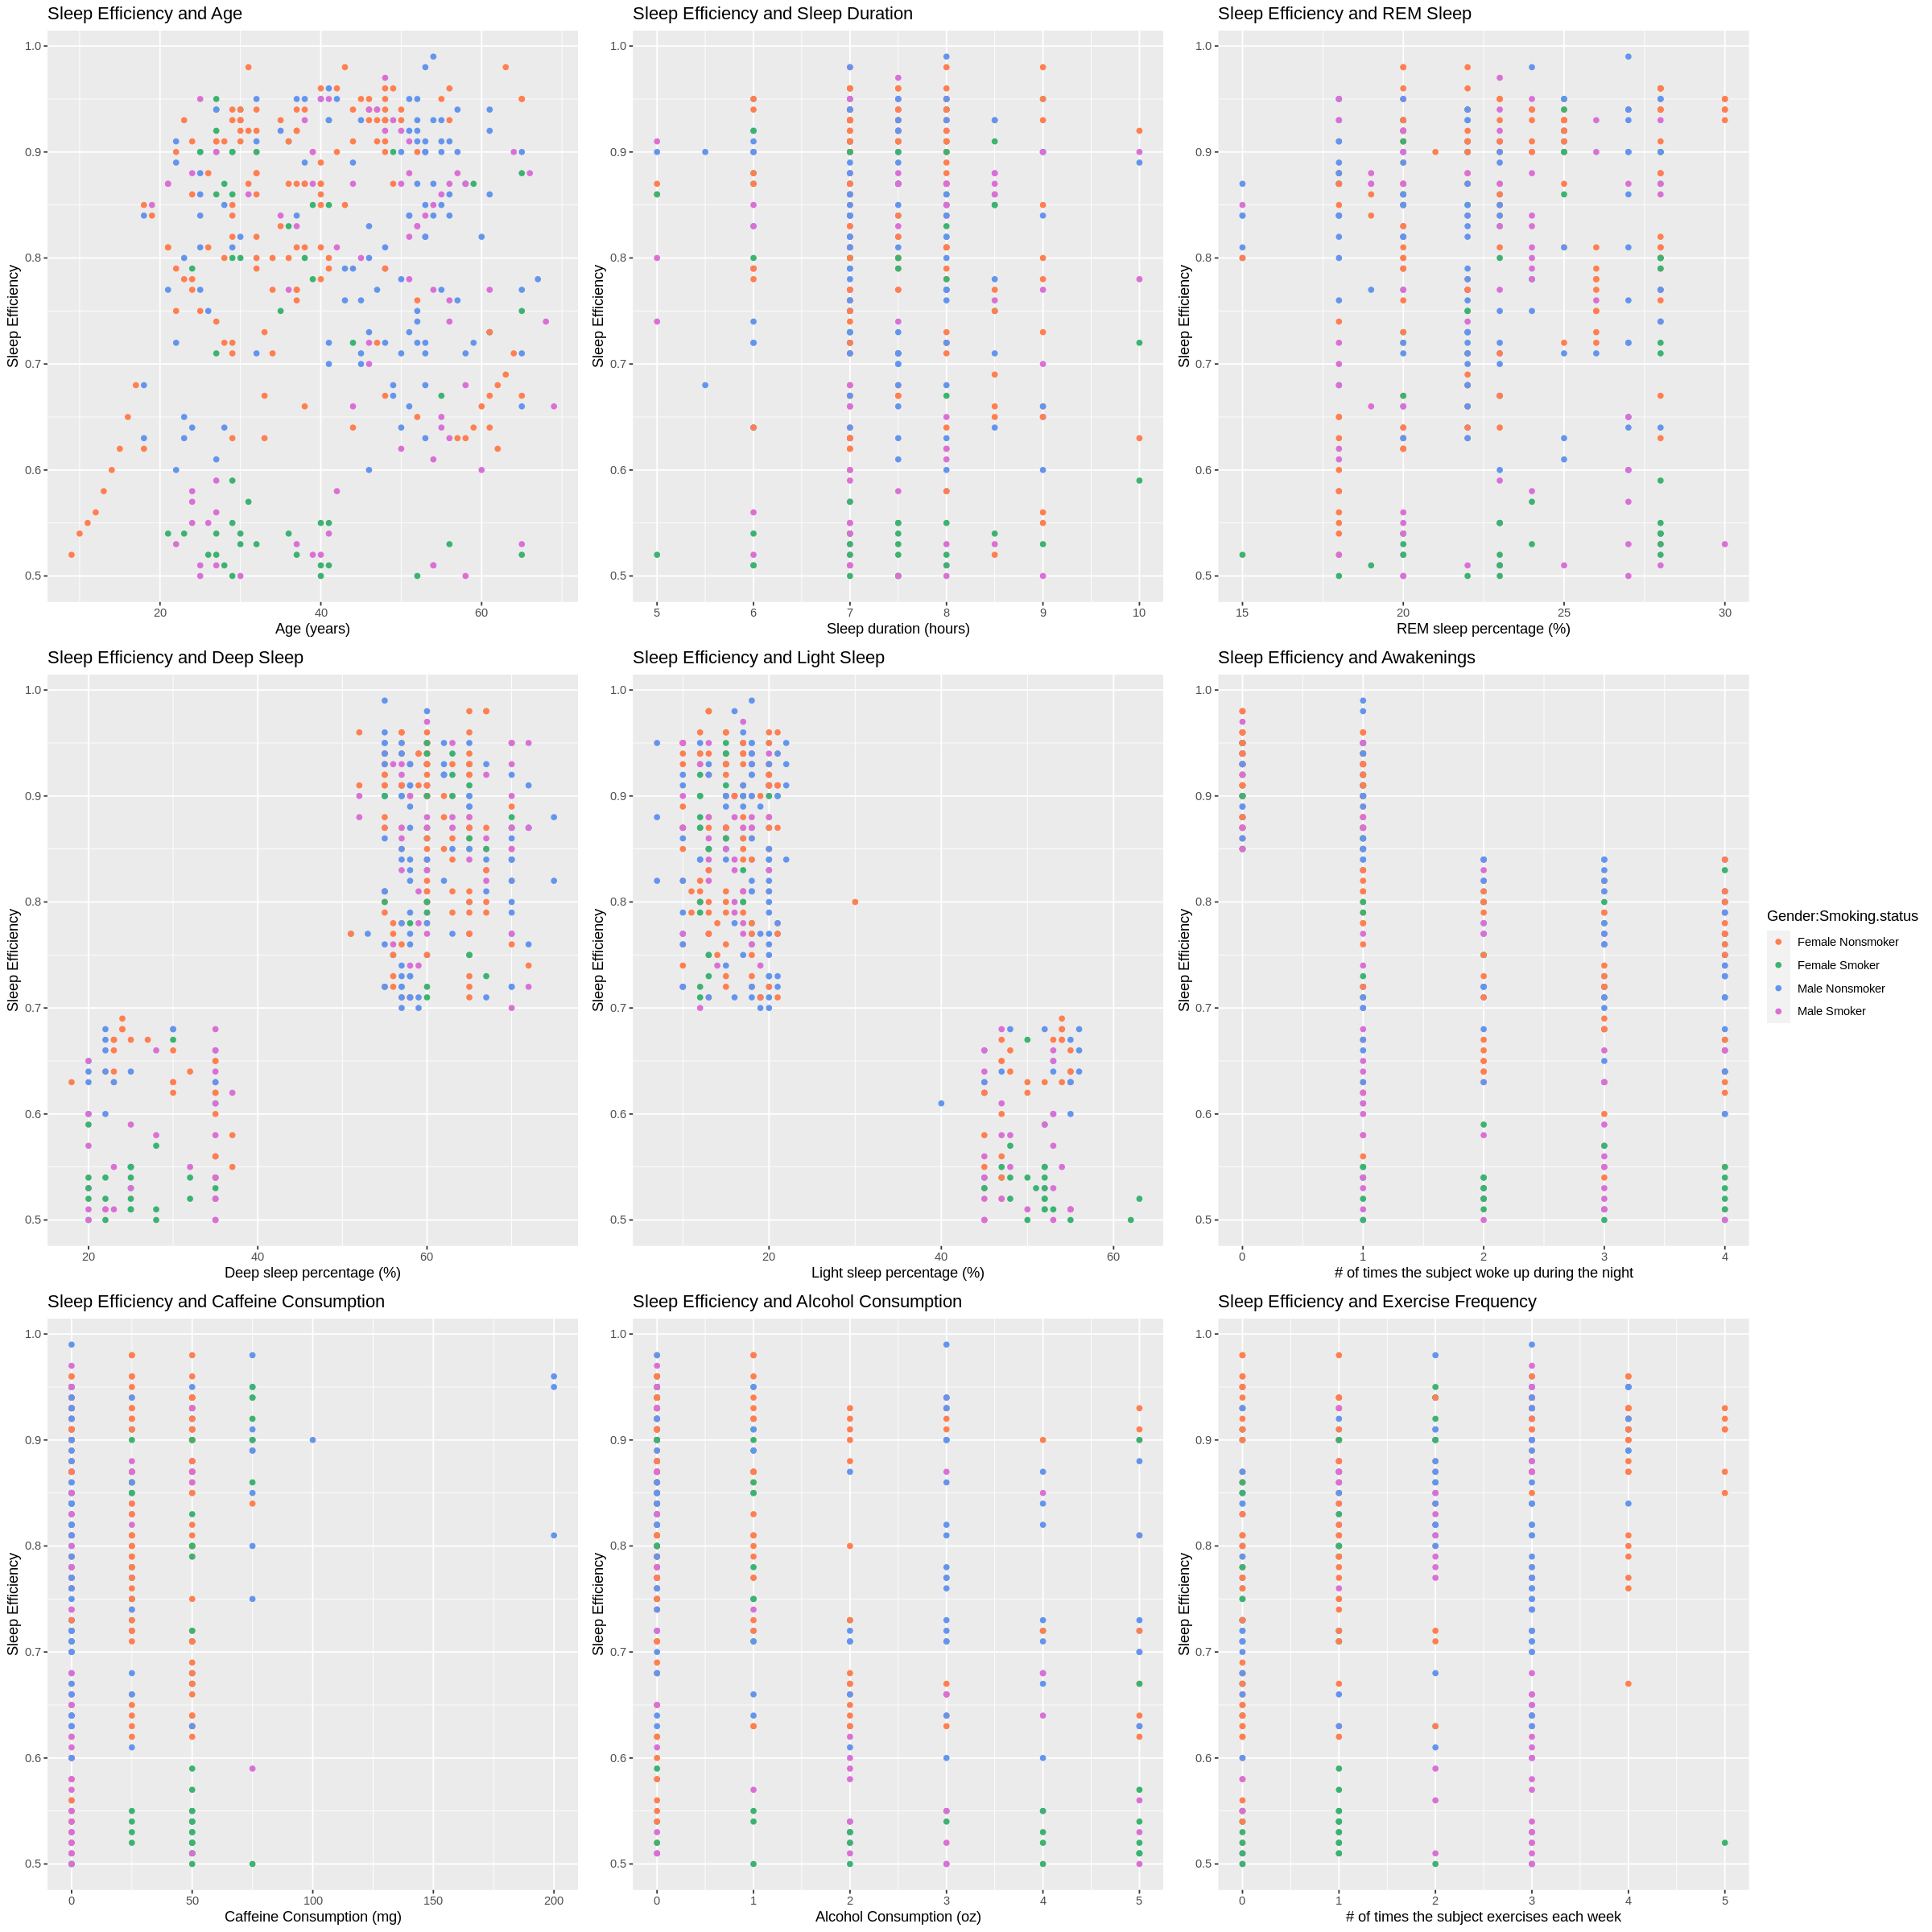

In [81]:
#plot all scatterplots
options(repr.plot.width=20,repr.plot.height=20)
legend<-get_legend(plot_age)

plot_grid(plot_grid(   
plot_grid(
    plot_age + theme(legend.position = 'none'), 
    plot_dur + theme(legend.position = 'none'),
    plot_rem + theme(legend.position = 'none'), 
    ncol=3
),
plot_grid(
    plot_deep + theme(legend.position = 'none'), 
    plot_light + theme(legend.position = 'none'),
    plot_awake + theme(legend.position = 'none'), 
    ncol=3
),

plot_grid(
    plot_caf + theme(legend.position = 'none'), 
    plot_alc + theme(legend.position = 'none'), 
    plot_exer + theme(legend.position = 'none'), 
    ncol=3
),

ncol=1),

plot_grid(legend), rel_widths = c(1, 0.1))


TODO: Discuss plots: linear or nonlinear, positive or negative, strong/moderate/weak association, any outliers, grouping? and anything else that looks important

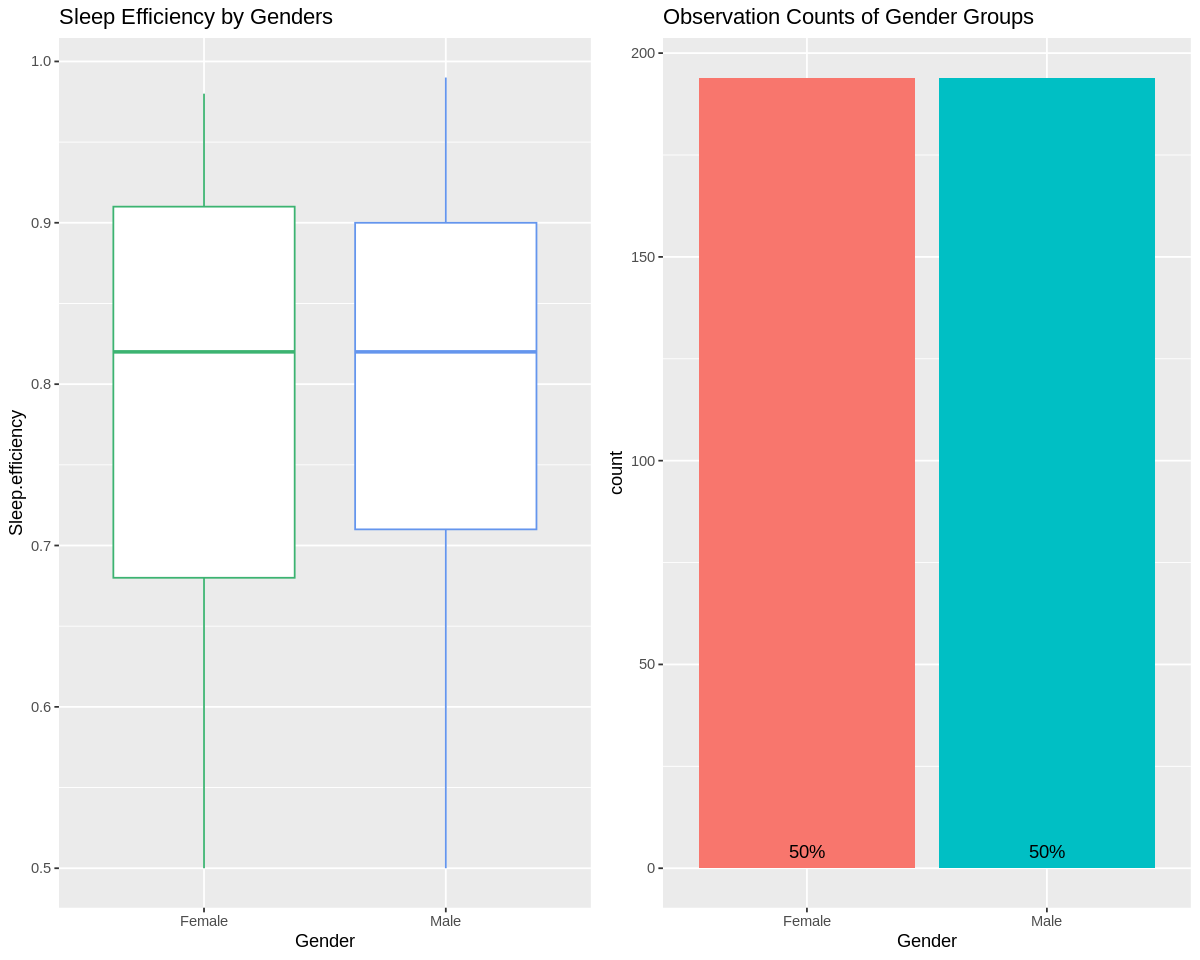

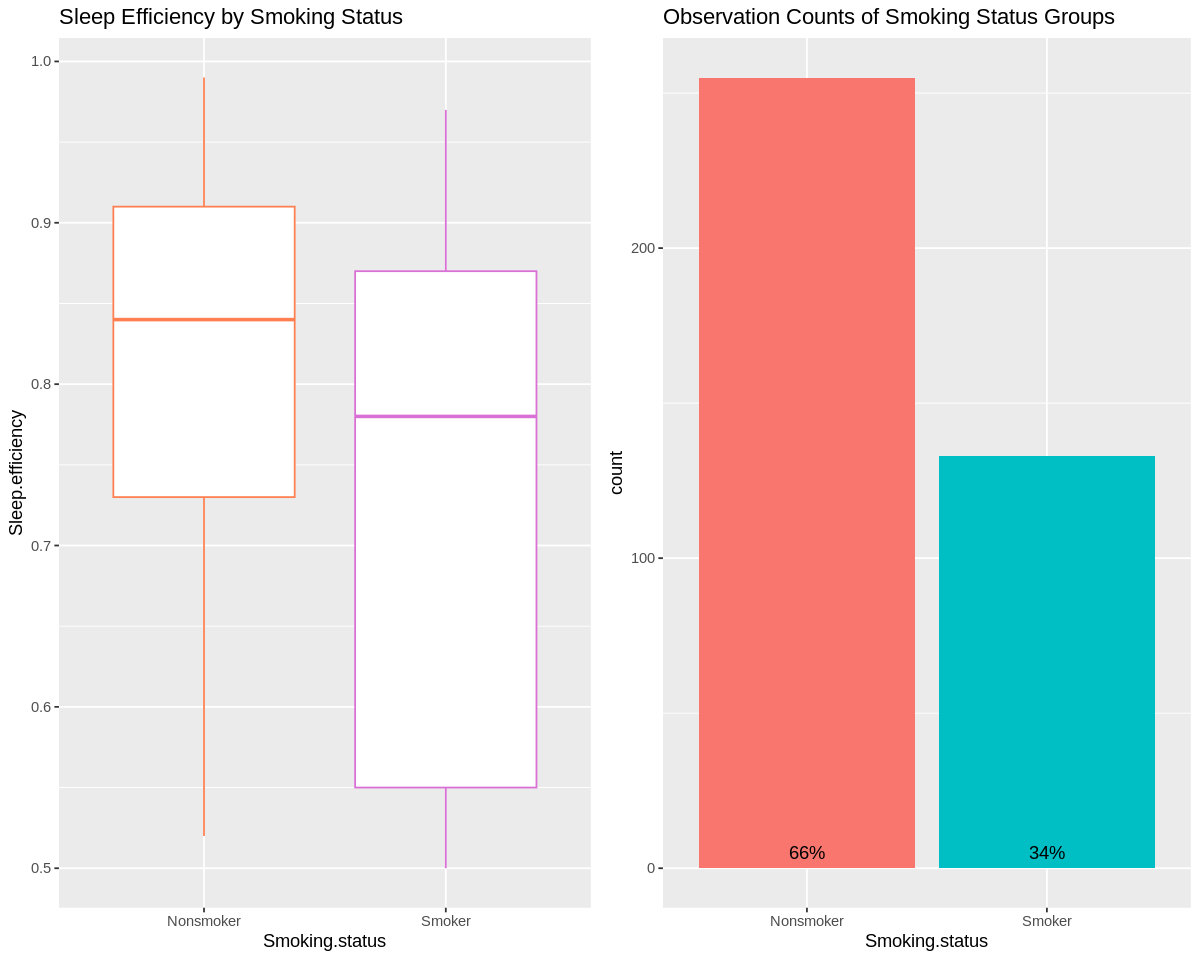

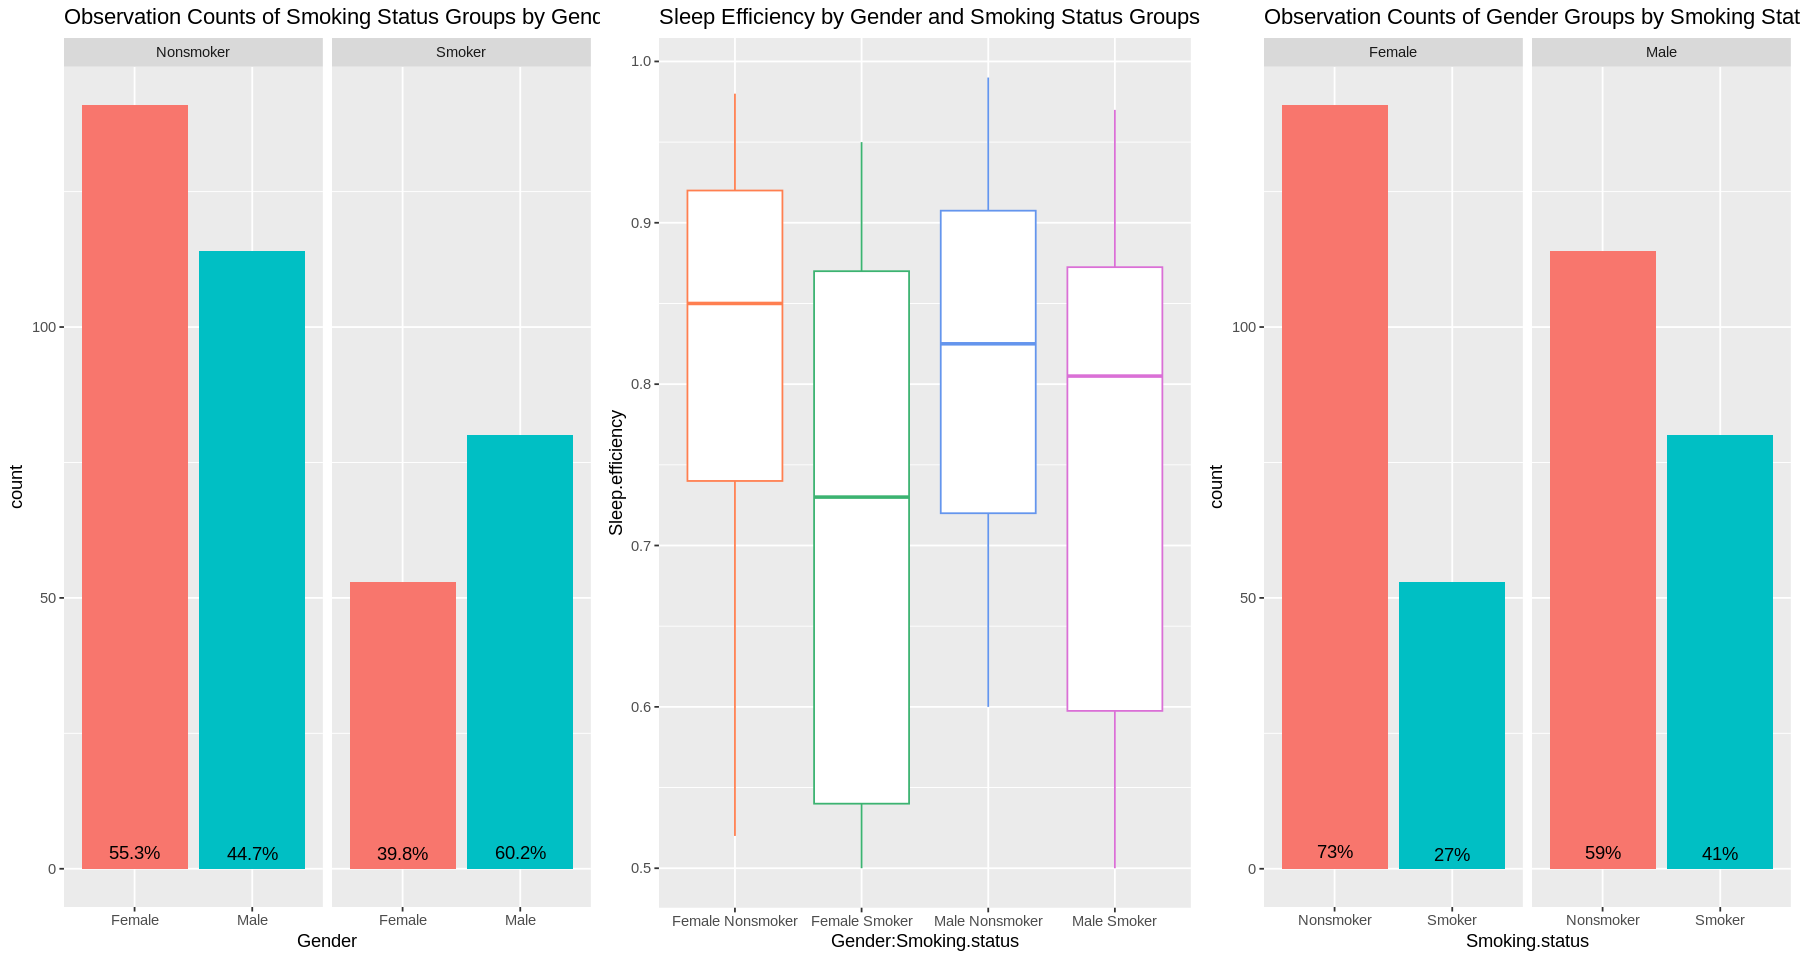

In [78]:
#plot scatterplot and barplots of each categorical variables
options(repr.plot.width=10,repr.plot.height=8)
#create scatterplot partitioned by groups
plot_gender <- ggplot(data, aes(x=Gender)) + 
    geom_bar(aes(y = ..count.., fill = factor(..x..)), stat="count", show.legend=FALSE) +
    geom_text(aes( label = scales::percent(..count../n), y= ..prop.. ), stat= "count", vjust = -.5) +
    scale_x_discrete(labels=c("0" = "Female", "1" = "Male"))+
    ggtitle("Observation Counts of Gender Groups")

plot_smoke <- ggplot(data, aes(x=Smoking.status)) + 
    geom_bar(aes(y = ..count.., fill = factor(..x..)), stat="count", show.legend=FALSE) +
    geom_text(aes( label = scales::percent(..count../n), y= ..prop.. ), stat= "count", vjust = -.5) +
    scale_x_discrete(labels=c('0' = "Nonsmoker",'1' = "Smoker"))+
    ggtitle("Observation Counts of Smoking Status Groups")

plot_genderbysmoke <- ggplot(data, aes(x=Gender,  group=Smoking.status)) + 
    geom_bar(aes(y = ..count.., fill = factor(..x..)), stat="count", show.legend=FALSE) +
    geom_text(aes( label = scales::percent(..prop..),
                   y= ..prop.. ), stat= "count", vjust = -.5) +
    facet_grid(~Smoking.status, labeller=as_labeller(c('0' = "Nonsmoker",'1' = "Smoker"))) +
    scale_x_discrete(labels=c("0" = "Female", "1" = "Male"))+
    ggtitle("Observation Counts of Smoking Status Groups by Gender")

plot_smokebygender <- ggplot(data, aes(x=Smoking.status,  group=Gender)) + 
    geom_bar(aes(y = ..count.., fill = factor(..x..)), stat="count", show.legend=FALSE) +
    geom_text(aes( label = scales::percent(..prop..),
                   y= ..prop.. ), stat= "count", vjust = -.5) +
    facet_grid(~Gender, labeller=as_labeller(c("0" = "Female", "1" = "Male"))) +
    scale_x_discrete(labels=c('0' = "Nonsmoker",'1' = "Smoker"))+
    ggtitle("Observation Counts of Gender Groups by Smoking Status")

#create boxplots to view if there are any siginificant differences between groups
boxplot_gendersmoke <- ggplot(data, aes(Gender:Smoking.status, Sleep.efficiency, color = Gender:Smoking.status)) + 
    geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=FALSE, show.legend=FALSE) + 
    scale_color_manual(values = c("coral", "mediumseagreen", "cornflowerblue", "orchid"),labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    scale_x_discrete(labels=c('Female Nonsmoker', 'Female Smoker', 'Male Nonsmoker', 'Male Smoker')) +
    ggtitle("Sleep Efficiency by Gender and Smoking Status Groups")
boxplot_gender <- ggplot(data, aes(Gender, Sleep.efficiency, color = Gender)) + 
    geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=FALSE, show.legend=FALSE) + 
    scale_color_manual(values = c("mediumseagreen", "cornflowerblue"),labels=c('Female','Male')) +
    scale_x_discrete(labels=c('Female','Male')) +
    ggtitle("Sleep Efficiency by Genders")
boxplot_smoke <- ggplot(data, aes(Smoking.status, Sleep.efficiency, color = Smoking.status)) + 
    geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=FALSE, show.legend=FALSE) + 
    scale_color_manual(values = c("coral", "orchid"),labels=c('Nonsmoker', 'Smoker')) +
    scale_x_discrete(labels=c('Nonsmoker', 'Smoker')) +
    ggtitle("Sleep Efficiency by Smoking Status")

plot_grid(boxplot_gender,plot_gender)
plot_grid(boxplot_smoke,plot_smoke)
options(repr.plot.width=15,repr.plot.height=8)
plot_grid(plot_genderbysmoke,boxplot_gendersmoke,plot_smokebygender, ncol=3)

"Summarize the plot (if needed)"

TO DO: Discuss plots: linear or nonlinear, positive or negative, strong/moderate/weak association, any outliers, grouping? and anything else that looks important


#### Model Selection - Full Model

TO DO: explain what we are doing for model selection. Also explain we are dropping the categorical values from this b/c it's incompatible with the step-wise algorithm. Or do we actually need to drop them since we've converted them into dummy variables already?

In [82]:
set.seed(2023)

step_data <- data |>
    select(-c(Smoking.status,Gender))
step_data$ID <- 1:n
step_data_train <- sample_n(step_data,size=0.5*n,replace=FALSE)
step_data_test <- anti_join(step_data,step_data_train,by="ID")

step_data_train <- step_data_train |> 
    select(-ID)
step_data_test <- step_data_test |> 
    select(-ID)

rmse <- function(u,v) {sqrt(mean((u-v)^2))}
head(step_data_train)

,Sleep.efficiency,Age,Sleep.duration,REM.sleep.percentage,Deep.sleep.percentage,Light.sleep.percentage,Awakenings,Caffeine.consumption,Alcohol.consumption,Exercise.frequency
,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.92,37,7.0,25,55,20,1,50,1,3
2,0.66,44,7.0,20,35,45,4,0,3,3
3,0.90,25,7.5,28,55,17,1,50,0,1
4,0.50,29,7.5,22,28,50,1,75,1,2
5,0.71,29,7.0,22,57,21,1,25,0,2
6,0.68,58,7.0,18,35,47,1,0,4,3


In [83]:
full_model <- lm(Sleep.efficiency~.,data=step_data_train)
pre_full_model <- predict(full_model,step_data_test)

full_model_RMSE <- tibble(Model="Full Model",
                          RMSE=rmse(step_data_train$Sleep.efficiency,pre_full_model))
full_model_RMSE

Warning message in predict.lm(full_model, step_data_test):
“prediction from a rank-deficient fit may be misleading”


Model,RMSE
<chr>,<dbl>
Full Model,0.1780283


#### Model Selection - Forward and Backward Selection

In [84]:
forward_select <- summary(regsubsets(x=Sleep.efficiency~.,
                                    nvmax=9,
                                    data=step_data_train,
                                    method="forward"))
forward_cp <- tibble(var=1:8,cp=forward_select$cp) |>
    arrange(cp)
forward_select
forward_cp

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“1  linear dependencies found”


Reordering variables and trying again:


Warning message in rval$lopt[] <- rval$vorder[rval$lopt]:
“number of items to replace is not a multiple of replacement length”


Subset selection object
Call: regsubsets.formula(x = Sleep.efficiency ~ ., nvmax = 9, data = step_data_train, 
    method = "forward")
9 Variables  (and intercept)
                       Forced in Forced out
Age                        FALSE      FALSE
Sleep.duration             FALSE      FALSE
REM.sleep.percentage       FALSE      FALSE
Deep.sleep.percentage      FALSE      FALSE
Awakenings                 FALSE      FALSE
Caffeine.consumption       FALSE      FALSE
Alcohol.consumption        FALSE      FALSE
Exercise.frequency         FALSE      FALSE
Light.sleep.percentage     FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: forward
         Age Sleep.duration REM.sleep.percentage Deep.sleep.percentage
1  ( 1 ) " " " "            " "                  " "                  
2  ( 1 ) " " " "            " "                  " "                  
3  ( 1 ) "*" " "            " "                  " "                  
4  ( 1 ) "*" " "            " "                  " "

var,cp
<int>,<dbl>
4,2.740637
5,3.529309
3,3.853241
6,4.713344
2,5.647597
7,6.089748
8,8.000000
1,87.558009


In [85]:
forward_model <- lm(Sleep.efficiency~Light.sleep.percentage+Awakenings+Age+Exercise.frequency,data=step_data_train)
pre_forward_model <- predict(forward_model,step_data_test)
forward_model_RMSE <- tibble(Model="Forward Model",
                             RMSE=rmse(step_data_train$Sleep.efficiency,pre_forward_model))
forward_model_RMSE

Model,RMSE
<chr>,<dbl>
Forward Model,0.1787038


In [36]:
backward_select <- summary(regsubsets(x=Sleep.efficiency~.,
                                    nvmax=11,
                                    data=step_data_train,
                                    method="backward"))
backward_cp <- tibble(var=1:10,cp=backward_select$cp) |>
    arrange(cp)
backward_select
backward_cp

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“1  linear dependencies found”


Reordering variables and trying again:


Warning message in rval$lopt[] <- rval$vorder[rval$lopt]:
“number of items to replace is not a multiple of replacement length”


Subset selection object
Call: regsubsets.formula(x = Sleep.efficiency ~ ., nvmax = 11, data = step_data_train, 
    method = "backward")
11 Variables  (and intercept)
                       Forced in Forced out
Age                        FALSE      FALSE
Bedtime                    FALSE      FALSE
Wakeup.time                FALSE      FALSE
Sleep.duration             FALSE      FALSE
REM.sleep.percentage       FALSE      FALSE
Deep.sleep.percentage      FALSE      FALSE
Awakenings                 FALSE      FALSE
Caffeine.consumption       FALSE      FALSE
Alcohol.consumption        FALSE      FALSE
Exercise.frequency         FALSE      FALSE
Light.sleep.percentage     FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: backward
          Age Bedtime Wakeup.time Sleep.duration REM.sleep.percentage
1  ( 1 )  " " " "     " "         " "            " "                 
2  ( 1 )  " " " "     " "         " "            " "                 
3  ( 1 )  " " " "     " "        

var,cp
<int>,<dbl>
5,1.932414
6,3.123472
4,3.187561
7,4.505243
3,5.027391
8,6.373690
9,8.005707
10,10.000000
2,30.376600


In [37]:
backward_model <- lm(Sleep.efficiency~Deep.sleep.percentage+Awakenings+REM.sleep.percentage+Age+Exercise.frequency,data=step_data_train)
pre_backward_model <- predict(backward_model,step_data_test)
backward_model_RMSE <- tibble(Model="Backward Model",
                             RMSE=rmse(step_data_train$Sleep.efficiency,pre_backward_model))
backward_model_RMSE

Model,RMSE
<chr>,<dbl>
Backward Model,0.1782972


#### RMSE Comparison of the Models

In [38]:
rbind(full_model_RMSE,forward_model_RMSE,backward_model_RMSE) |>
arrange(RMSE)

Model,RMSE
<chr>,<dbl>
Full Model,0.1781597
Backward Model,0.1782972
Forward Model,0.1787038


"Describe/Compare the results here"

basically, we just use all of the variables for our linear and quadratic models. i'll add more detail to this explanation later.

#### Linear Models

In [ ]:
# Code goes here

"Description of results go here"

#### Quadratic Models

In [ ]:
# Code goes here

"Description of results go here"

#### Error Analysis (Extra if needed, Residual Plots and stuff like that ya know)

In [ ]:
# Code goes here

"Description of plot goes here"

## 3. Conclusion

"Discuss results and findings here, talk about the model selection process, which one was the best, compare the R^2 of the linear and quadratic models, etc..."
A short synopsis of the findings from the analysis should be presented, along with any other pertinent comments of interest. Care should be taken to address the initial research question(s).

#### Improvements

"Write improvements and limitiations of the project here"

#### References

García, A., Angel, J. D., Borrani, J., Ramirez, C., & Valdez, P. (2021). Sleep deprivation effects on basic cognitive processes: which components of attention, working memory, and executive functions are more susceptible to the lack of sleep?. *Sleep science (Sao Paulo, Brazil)*, 14(2), 107–118. <https://doi.org/10.5935/1984-0063.20200049> 
                            
Anikó Kusztor, Liisa Raud, Bjørn E Juel, André S Nilsen, Johan F Storm, Rene J Huster, Sleep deprivation differentially affects subcomponents of cognitive control, *Sleep*, Volume 42, Issue 4, April 2019, zsz016, <https://doi.org/10.1093/sleep/zsz016>
